In [1]:
import numpy as np
import torch
import os
import pandas as pd
import itertools as it
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Models/utils.py .
from utils import *

# !pip install optuna
# import optuna

In [3]:
import numpy as np
!pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer

In [4]:
def read_range(f_path, segment_index, device):
  sub_dif = pd.read_csv(f_path, header=None).iloc[:, segment_index]
  sub_dif = sub_dif.reset_index(inplace=False, drop=True)
  sub_dif = sub_dif.to_numpy().reshape(-1, len(segment_index)*3)
  sub_dif = torch.from_numpy(sub_dif).to(device)
  return sub_dif

def nRMSE_compute():
    tot_loss = torch.sum(torch.sum(((L_tar.to(device) - L_pred.to(device))/my_range)** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss

def RMSE_compute():
    tot_loss = torch.sum(torch.sum(((L_tar.to(device) - L_pred.to(device)))** 2))
    tot_loss = torch.sqrt(tot_loss / (len(Test_List)*(101-input_frames)*segment_len))
    return tot_loss


def r2_compute():
    scaler = StandardScaler()
    scaled_y_true = scaler.fit_transform(L_tar.reshape(-1, 1))
    scaled_y_pred = scaler.transform(L_pred.reshape(-1, 1))

    r2 = r2_score(scaled_y_true, scaled_y_pred)
    return r2

In [5]:
input_frames, predicted_frames, my_stride = 25, 1, 1
num_of_sub = 20
val_sub = [2, 8, 9, 14]
test_sub = [13, 15]
segment_inds = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
body_segment_name = 'Arm'

In [6]:
# path to proceesed folder
proceesed_path = '/content/drive/MyDrive/DATA/Normalized'
val_pathes = []
for i in val_sub:
  val_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

test_pathes = []
for i in test_sub:
  test_pathes.append(os.path.join(proceesed_path, f's{i}_fn'))

path_to_subject_mean = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'mean.csv')
path_to_subject_std = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'std.csv')
path_to_subject_range = os.path.join('/content/drive/MyDrive/data normalization/mean-std', 'dif.csv')

path_to_folder = '/content/drive/MyDrive/Models/LSTM_Arm'

In [7]:
val_pathes, test_pathes

(['/content/drive/MyDrive/DATA/Normalized/s2_fn',
  '/content/drive/MyDrive/DATA/Normalized/s8_fn',
  '/content/drive/MyDrive/DATA/Normalized/s9_fn',
  '/content/drive/MyDrive/DATA/Normalized/s14_fn'],
 ['/content/drive/MyDrive/DATA/Normalized/s13_fn',
  '/content/drive/MyDrive/DATA/Normalized/s15_fn'])

In [8]:
Val_List = []
Test_List = []

for val_path in val_pathes:
  test_ls, segment_len, _ = read_test(val_path, body_segment_name)
  Val_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

for test_path in test_pathes:
  test_ls, segment_len, _ = read_test(test_path, body_segment_name)
  Test_List.extend(test_ls)

print(len(test_ls), test_ls[0].shape)

204 (101, 49)
204 (101, 49)


In [9]:
train_data = []
val_data = []
test_data = []

for i in range(1, num_of_sub+1):
  if i in val_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    val_data.extend(dd)
  elif i in test_sub:
    dd, path2files = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    test_data.extend(dd)
  else:
    dd, _ = windower(proceesed_path, i, input_frames, predicted_frames, my_stride, body_segment_name)
    train_data.extend(dd)




In [10]:
len(train_data), len(val_data), len(test_data)

(201096, 58824, 31008)

## Data Loader

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [12]:
my_mean = pd.read_csv(path_to_subject_mean, header=None).iloc[:, segment_inds]
my_std = pd.read_csv(path_to_subject_std, header=None).iloc[:, segment_inds]
my_range = read_range(path_to_subject_range, segment_inds, device)

denormalize_transform = Denormalizer(my_mean, my_std, predicted_frames, device)
tot_denormalize_transform = Denormalizer(my_mean, my_std, 101, device)

train_ds = MyDataset(train_data)
val_ds = MyDataset(val_data)
test_ds = MyDataset(test_data)

In [13]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                      shuffle=True)

## Model Implementation

In [14]:
model = Lstm(n_inputs=segment_len+7, n_hidden=128, n_rnnlayers=1, n_outputs=segment_len, n_pr_frames=1, device=device)


In [15]:
model.to(device)

Lstm(
  (lstm): LSTM(49, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)

In [16]:
count_parameters(model)

194090

## Training Model

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, betas=(0.9, 0.98), eps=1e-09)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                       patience=5, min_lr=1e-7, verbose=True)


In [18]:
epochs = 150
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
DTWs = np.zeros(epochs)
best_val_loss = float('inf')
best_DTW = float('inf')
for it in range(epochs):
  train_losses[it] = train_loop(model,
                                criterion,
                                optimizer,
                                train_dl,
                                val_dl,
                                epochs,
                                scheduler,
                                denormalize_transform,
                                device)

  val_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              val_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)
  test_losses[it] = test_loop(model,
                              criterion,
                              optimizer,
                              train_dl,
                              test_dl,
                              epochs,
                              scheduler,
                              denormalize_transform,
                              device)

#   DTWs[it] = RMSE_compute(model)


  if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {train_losses[it]:.5f}, Validation Loss: {val_losses[it]:.5f}, Test Loss: {test_losses[it]:.5f},DTW: {DTWs[it]:.5f}')
  if scheduler is not None:
    scheduler.step(val_losses[it])

  if test_losses[it] < best_val_loss:
    best_val_loss = test_losses[it]
    torch.save(model.state_dict(), "best_val_model_params.pt")
    torch.save(model.state_dict(), os.path.join(path_to_folder, "best_val_model_params.pt"))

  # if DTWs[it] < best_DTW:
  #   best_DTW = DTWs[it]
  #   torch.save(model.state_dict(), "best_DTW_model_params.pt")
  #   torch.save(model.state_dict(), os.path.join(path_to_folder, "best_DTW_model_params.pt"))

Epoch 5/150, Train Loss: 4.40824, Validation Loss: 20.67274, Test Loss: 10.52691,DTW: 0.00000
Epoch 10/150, Train Loss: 2.19404, Validation Loss: 11.14465, Test Loss: 3.62037,DTW: 0.00000
Epoch 15/150, Train Loss: 1.62854, Validation Loss: 10.75728, Test Loss: 3.41245,DTW: 0.00000
Epoch 20/150, Train Loss: 1.27490, Validation Loss: 7.76663, Test Loss: 2.02182,DTW: 0.00000
Epoch 25/150, Train Loss: 1.07260, Validation Loss: 7.22302, Test Loss: 1.90211,DTW: 0.00000
Epoch 30/150, Train Loss: 0.90444, Validation Loss: 6.64838, Test Loss: 2.01983,DTW: 0.00000
Epoch 35/150, Train Loss: 0.78419, Validation Loss: 5.35897, Test Loss: 0.91943,DTW: 0.00000
Epoch 40/150, Train Loss: 0.69672, Validation Loss: 5.27533, Test Loss: 1.03275,DTW: 0.00000
Epoch 45/150, Train Loss: 0.62983, Validation Loss: 4.78019, Test Loss: 0.83047,DTW: 0.00000
Epoch 50/150, Train Loss: 0.57423, Validation Loss: 4.84949, Test Loss: 0.98534,DTW: 0.00000
Epoch 55/150, Train Loss: 0.52647, Validation Loss: 4.87200, Test L

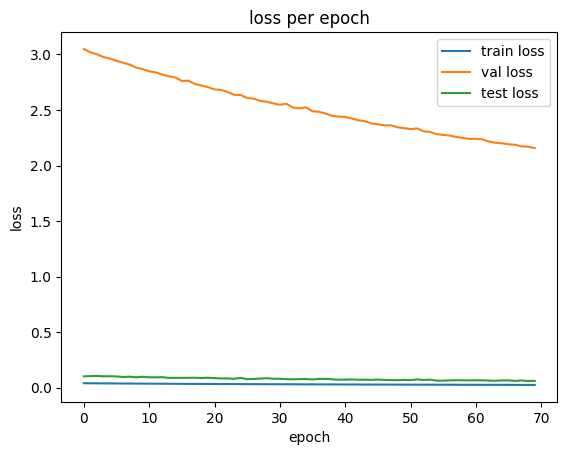

In [19]:
plt.plot(train_losses[80: ], label='train loss')
plt.plot(val_losses[80:], label='val loss')
plt.plot(test_losses[80:], label='test loss')
plt.legend()
plt.title("loss per epoch")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [20]:
L_v_tar, L_v_pred = L_Pred(test_ls, 0, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)

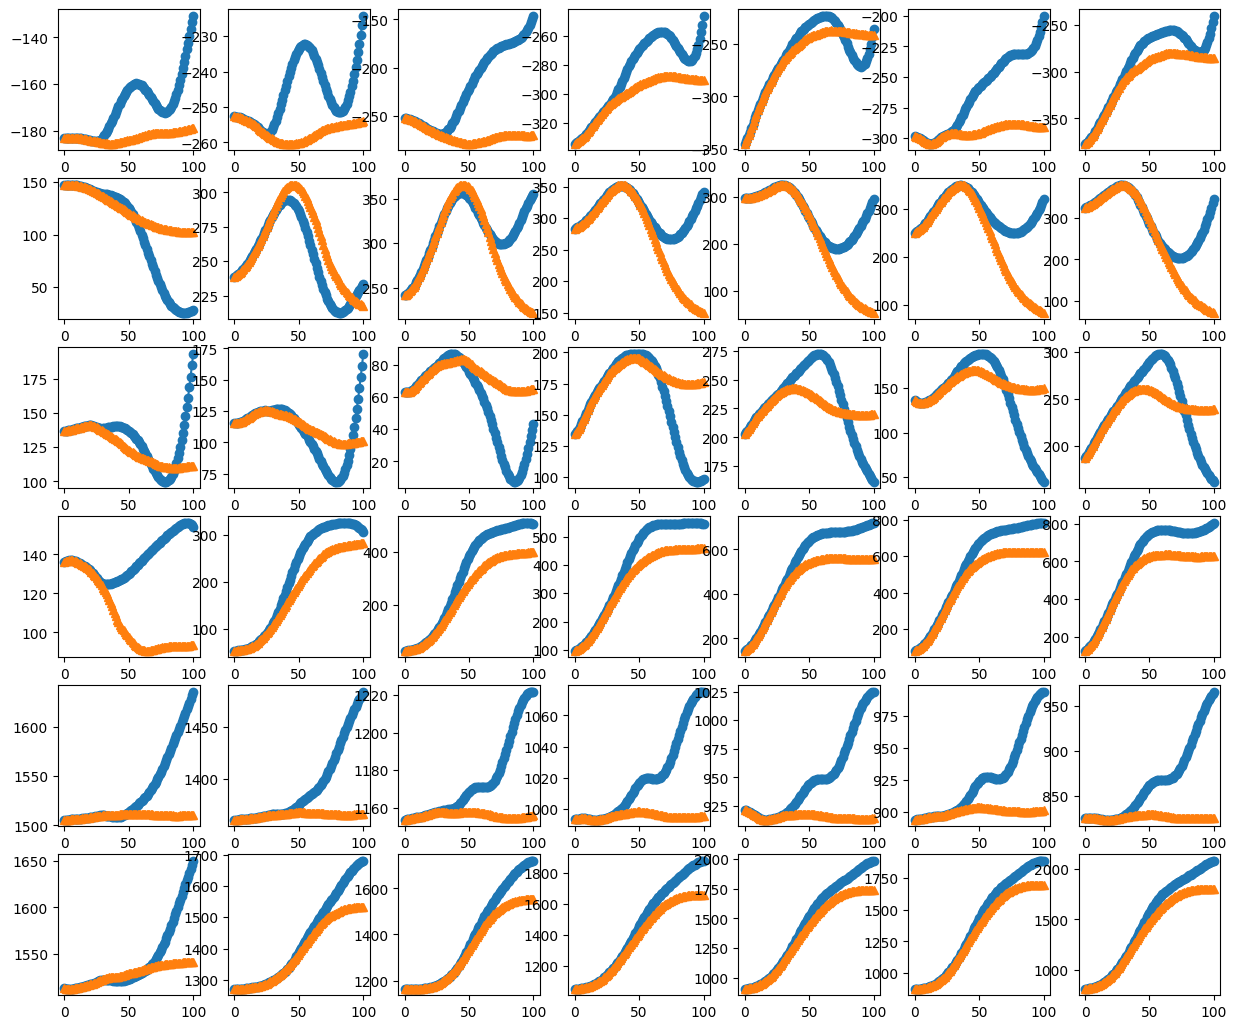

In [21]:
plt.figure(figsize=(15, 15))
for i in range(L_v_tar.shape[2]):
  plt.subplot(7, 7, i+1)
  plt.plot(L_v_pred.squeeze().detach().cpu()[:, i], '-o', label='forecast prediction')
  plt.plot(L_v_tar.squeeze().detach().cpu()[:, i],'-^', label='forecast target' )
plt.savefig("output.png")

## Best MSE


In [22]:
# Load best val model
model = Lstm(n_inputs=segment_len+7, n_hidden=128, n_rnnlayers=1, n_outputs=segment_len, n_pr_frames=1, device=device)


model.to(device)
model.load_state_dict(torch.load(os.path.join(path_to_folder, "best_val_model_params.pt")))
model.eval()

Lstm(
  (lstm): LSTM(49, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)

In [23]:
i = 0
L_tar = torch.zeros(101*len(Test_List), segment_len)
L_pred = torch.zeros(101*len(Test_List), segment_len)
for j in range(len(Test_List)):
    L_v_tar, L_v_pred = L_Pred(Test_List, j, model, tot_denormalize_transform, input_frames, predicted_frames, segment_len, device)
    L_tar[0+i:101+i, :] = L_v_tar
    L_pred[0+i:101+i, :] = L_v_pred
    i = i + 101

In [24]:
RMSE_loss = RMSE_compute()
nRMSE_loss = nRMSE_compute()
r2_m = r2_compute()
print(f'RMSE: {RMSE_loss}, nRMSE: {nRMSE_loss}, r2: {r2_m}')

RMSE: 114.72960662841797, nRMSE: 0.09343831204973996, r2: 0.9613354954784965
